# **Making Design with Pix2Pix**

Original Development: Image-to-Image Translation with Conditional Adversarial Nets: https://phillipi.github.io/pix2pix/

Paper available at https://arxiv.org/abs/1611.07004


Modified from the version published at https://www.tensorflow.org/tutorials/generative/pix2pix
(Last modified on 1 December 2022 by William Huang ucfnhua@ucl.ac.uk).



---
Input image resolution: [(256, 256), (256, 256)]


Input image example:

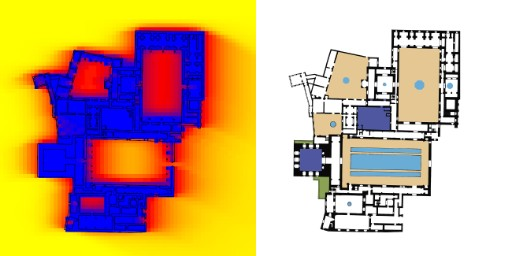

Conditional image example:

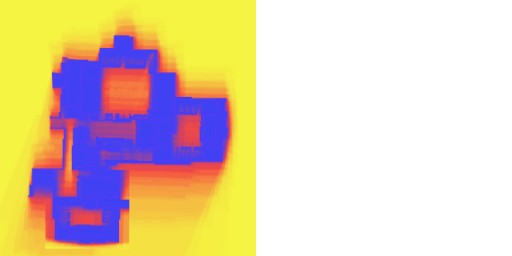

Image data format: .jpg or .png

Datasets structure: a google drive folder incorporating three subfolders named 'train', 'test', 'val'



---
Segmentation scheme:

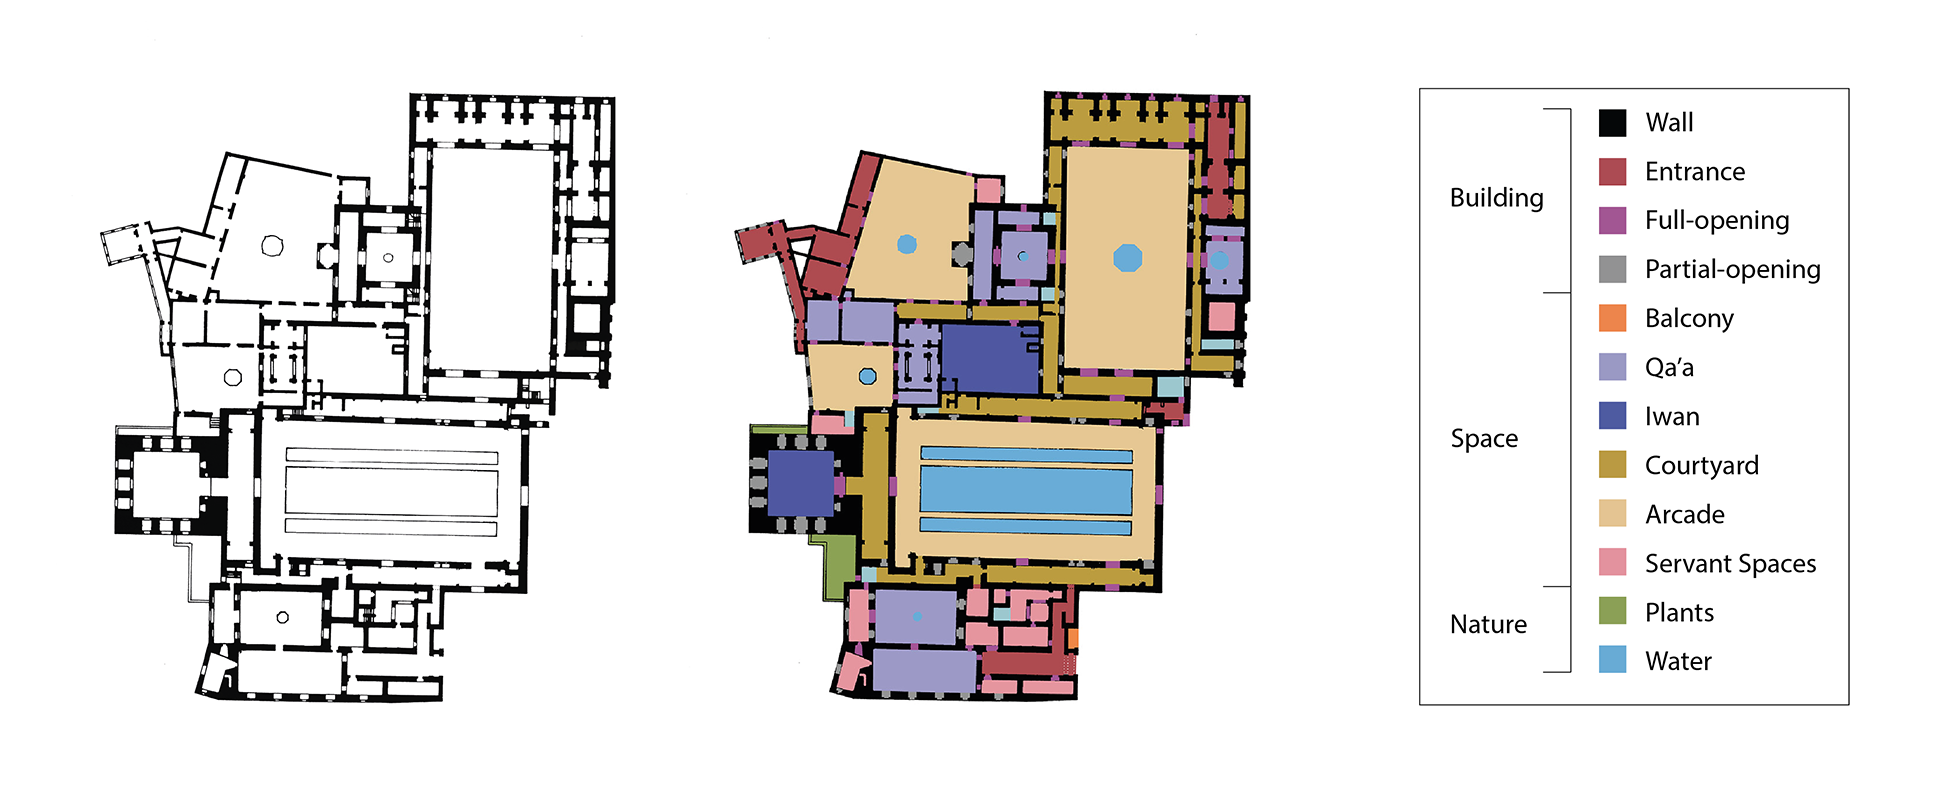

## Import libraries

In [5]:
import os
import sys
import time
import numpy as np

import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from IPython import display

from google.colab import drive

## List devices

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13737578962346603998
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15213863277738429498
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## Load the dataset

In [7]:
# Place the dataset in your Google Drive
drive.mount("/content/drive")

######## set dataset path ########-------------------------------------------------------------------------
folder_name = 'Dataset' #@param{type:"string"}
path = "/content/drive/My Drive/" + folder_name
# path = "/content/drive/My Drive/ml_test/0.jpg

os.chdir(path) # change the current working directory to the given path
os.listdir(path) # list all the entries in the directory given by path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['val', 'test', 'train', 'logs', 'model.png', 'generated_image.png']

In [8]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 256
print(path)

def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, w:, :] # right image
  input_image = image[:, :w, :] # left image

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

/content/drive/My Drive/Dataset


## Plot input-target sample

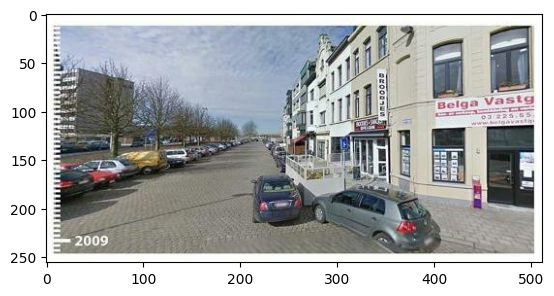

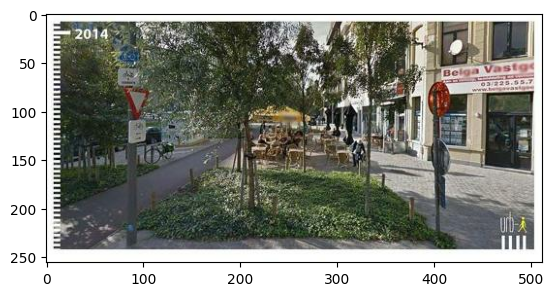

In [9]:
file_name = 0 #@param {type:"slider", min:0, max:29, step:1}
file_format = '.jpg' #@param [".jpg", ".png", ".bmp"] {allow-input: true}
inp, re = load(path + '/train/' + str(file_name) + file_format) ######## paste the path to one any image within the training set ########---------------------------------------------------------------

# casting to int for matplotlib to show the image
plt.figure()
#plt.axis('off')
plt.imshow(inp/255.0)

plt.figure()
#plt.axis('off')
plt.imshow(re/255.0)

## Data preprocessing & augmentation

In [10]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, 256, 512, 3])  # Adjust the size to 256x512x3

    return cropped_image[0], cropped_image[1]

# Normalize the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resize to 286x572x3
    input_image, real_image = resize(input_image, real_image, 286, 572)

    # Randomly crop to 256x512x3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


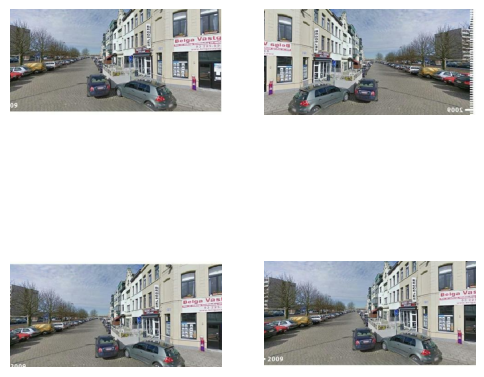

In [11]:
# inspect some of the preprocessed output
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

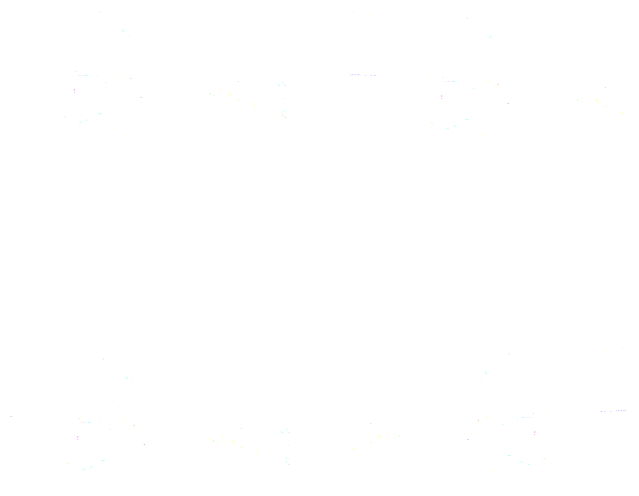

In [12]:
import matplotlib.pyplot as plt

# Assuming 'inp' and 're' are your input and real images

plt.figure(figsize=(8, 8))  # Adjust figsize based on your preference
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    # Since the images are normalized to [-1, 1], we need to scale them back to [0, 1] for display
    plt.imshow((rj_inp + 1) / 2)  # Scale back to [0, 1]
    plt.axis('off')
plt.show()


In [13]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_val(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Input pipeline

In [14]:
train_dataset = tf.data.Dataset.list_files(path+'/train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [15]:
test_dataset = tf.data.Dataset.list_files(path+'/test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [16]:
val_dataset = tf.data.Dataset.list_files(path+'/val/*.jpg')
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

## Build generator (U-Net)

In [17]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 256, 3)
(1, 256, 512, 3)


In [18]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 512, 3])  # Adjusted input shape

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 256, 64)
        downsample(128, 4),  # (bs, 64, 128, 128)
        downsample(256, 4),  # (bs, 32, 64, 256)
        downsample(512, 4),  # (bs, 16, 32, 512)
        downsample(512, 4),  # (bs, 8, 16, 512)
        downsample(512, 4),  # (bs, 4, 8, 512)
        downsample(512, 4),  # (bs, 2, 4, 512)
        downsample(512, 4),  # (bs, 1, 2, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 8, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 16, 1024)
        upsample(512, 4),  # (bs, 16, 32, 1024)
        upsample(256, 4),  # (bs, 32, 64, 512)
        upsample(128, 4),  # (bs, 64, 128, 256)
        upsample(64, 4),  # (bs, 128, 256, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh')  # (bs, 256, 512, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128, 256, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 128, 128)         131584    ['sequential_2[0][0]']        
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 64, 256)          525312    ['sequential_3[0][0]']        
                                                                                              

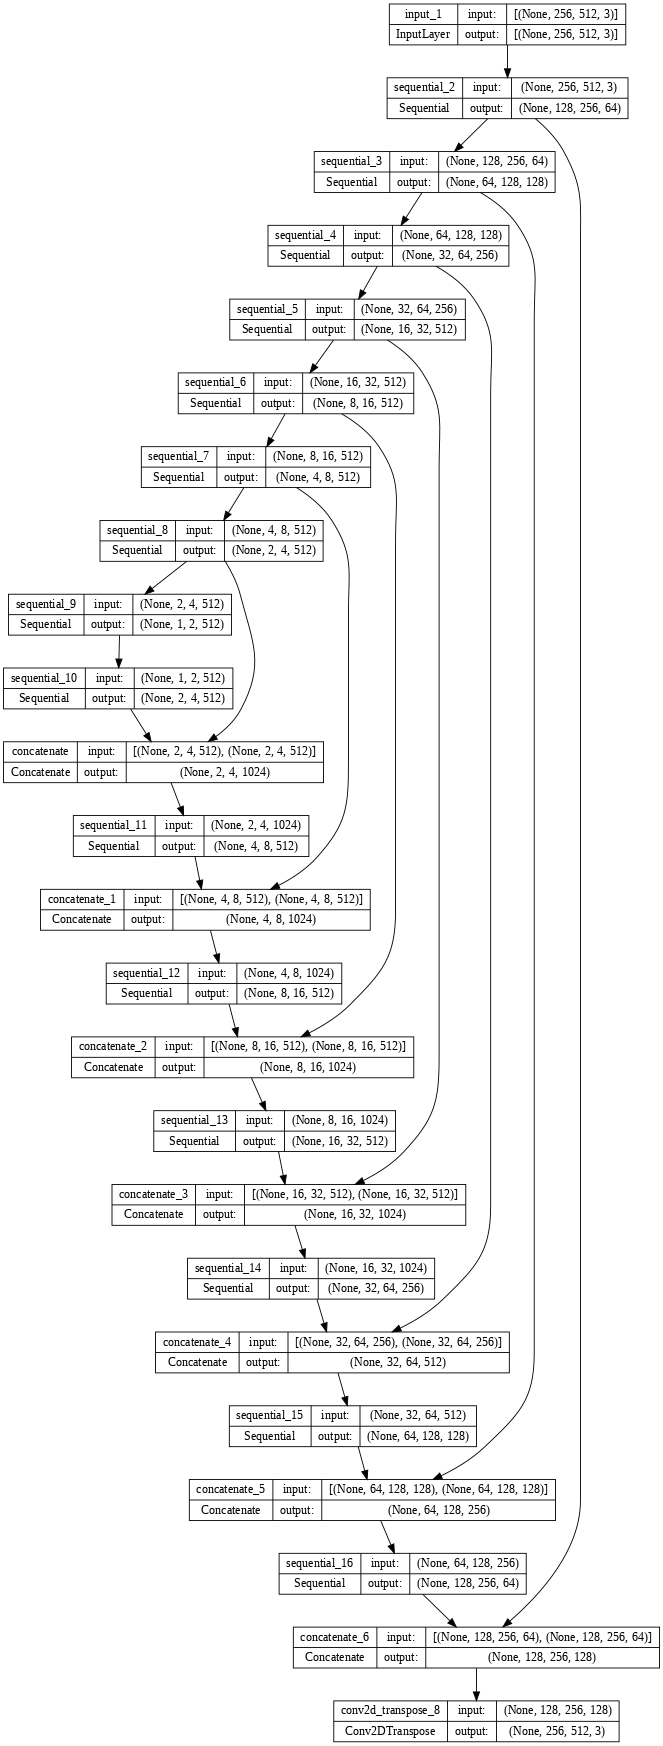

In [19]:
generator = Generator()
generator.summary()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

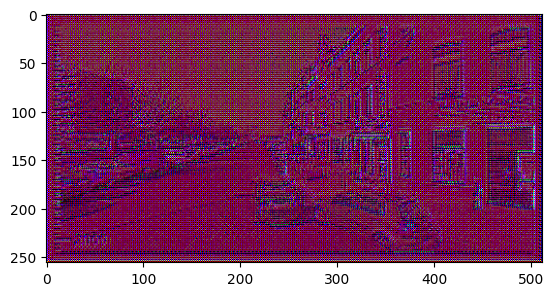

In [20]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

## Build discriminator

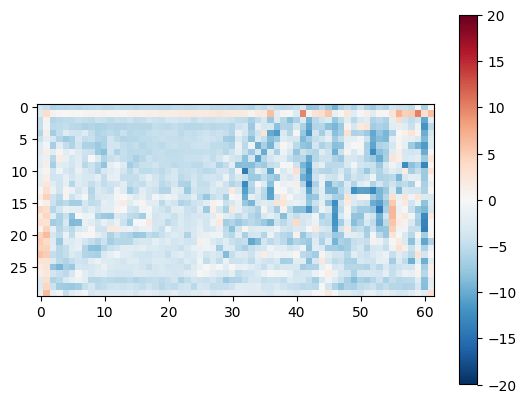

In [21]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 512, 3], name='input_image')  # Corrected input shape
    tar = tf.keras.layers.Input(shape=[256, 512, 3], name='target_image')  # Corrected input shape

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 512, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 256, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 128, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 64, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 66, 256)  # Adjusted padding for stride 1 convolutions
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (bs, 31, 63, 512)  # Adjusted output shape for stride 1 convolutions

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 65, 512)  # Adjusted padding for stride 1 convolutions

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 62, 1)  # Adjusted output shape for stride 1 convolutions

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Assuming the 'loss_object' and 'downsample' functions are defined elsewhere

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

# Assuming 'inp' and 'gen_output' are defined elsewhere
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


## Define loss functions and optimiser

In [22]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
# set checkpoints
checkpoint_dir = path + '/training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

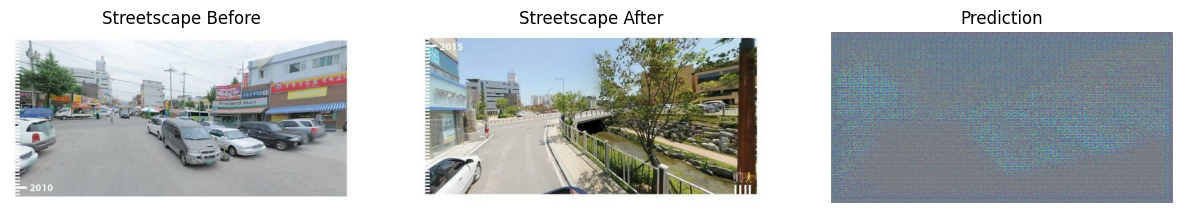

In [25]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]

  ######## Edit image titles (modify as needed)########------------------------
  title_domain_A = 'Streetscape Before' #@param {type:"string"}
  title_domain_B = 'Streetscape After' #@param {type:"string"}
  title_prediction = 'Prediction' #@param {type:"string"}
  title = [title_domain_A, title_domain_B, title_prediction]

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig('generated_image.png')
  plt.show()

for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

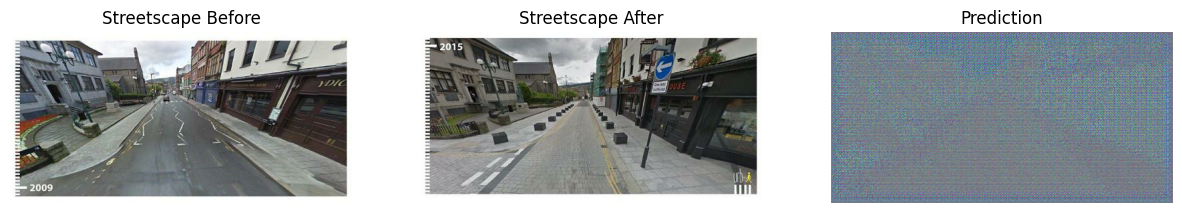

In [26]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 7))  # Adjusted figure size to match the aspect ratio of 256x512 images

    display_list = [test_input[0], tar[0], prediction[0]]

    # Customizing image titles
    title_domain_A = 'Streetscape Before'
    title_domain_B = 'Streetscape After'
    title_prediction = 'Prediction'
    title = [title_domain_A, title_domain_B, title_prediction]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Rescale images from [-1, 1] to [0, 1] for display
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')

    # Save the generated image
    plt.savefig('generated_image.png')
    plt.show()

# Assuming 'generator' and 'test_dataset' are defined elsewhere
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)


## Training

In [38]:
EPOCHS = 200 #@param {type:"slider", min:1, max:1000, step:1}
######## set epochs number ########--------------------------------------------

import datetime
log_dir=path + "/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [39]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)


In [40]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs ------------------------------------------------------------------------------------
    saving_frequency = 100 #@param {type:"slider", min:1, max:100, step:1}
    if (epoch + 1) % saving_frequency == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)


In [41]:
!pip install -U tensorboard


In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

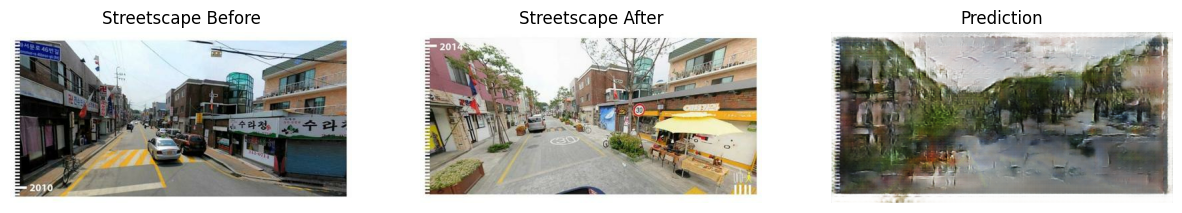

Epoch:  199
.......................................................................
Time taken for epoch 200 is 40.209808111190796 sec



In [43]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}
fit(train_dataset, EPOCHS, test_dataset)


## Restore the latest checkpoint and test

In [44]:
!ls {checkpoint_dir}
print(checkpoint_dir)

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/Dataset/training_checkpoints/': No such file or directory
/content/drive/My Drive/Dataset/training_checkpoints/


In [45]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create with the given design conditions
The condition images should be placed in the val dataset; this cell will use the images to generate the corresponding solutions.

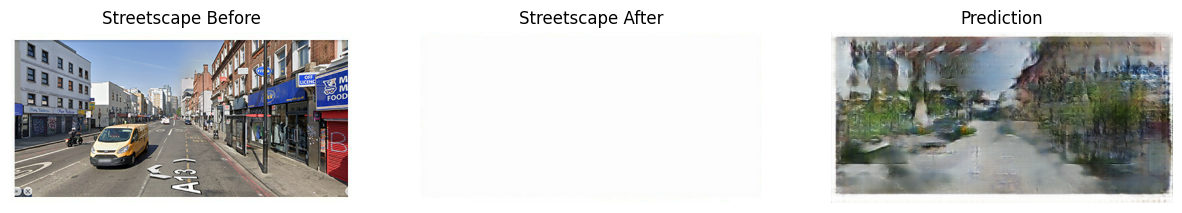

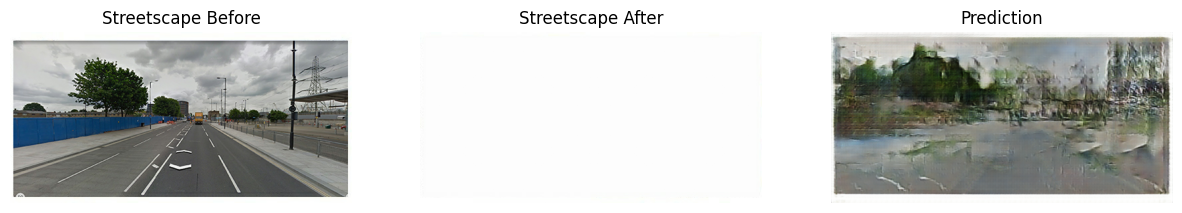

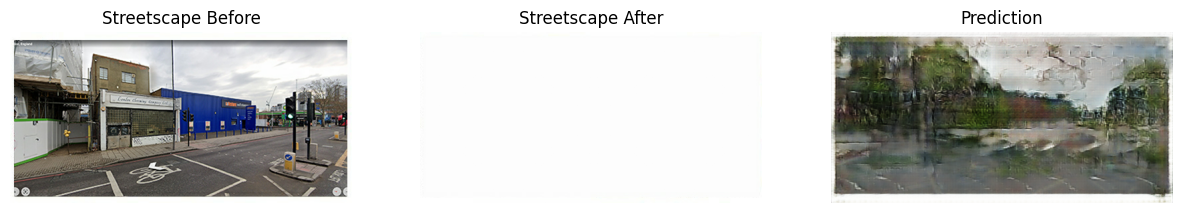

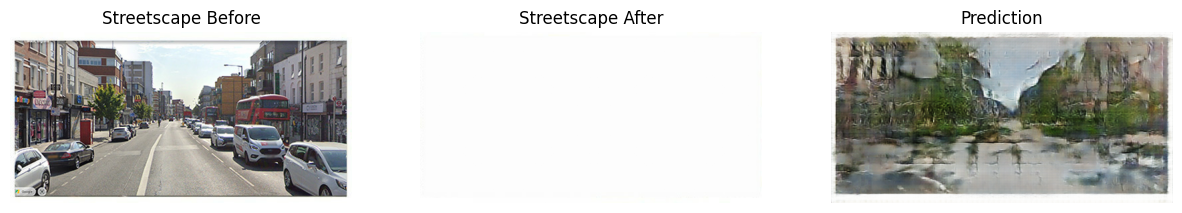

In [46]:
# Run the trained model on the provided example (design condition) from the val dataset
for inp, tar in val_dataset.take(-1): ######## generate predictive image by testing the model with one image (or more) within the training set ########-----------------------
  generate_images(generator, inp, tar) # call generate_images() method to finish the job